<a href="https://colab.research.google.com/github/prabhhav/JupyterNotebooks/blob/main/XGBoost_Bank_Marketing_Data_Set_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 

import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
!wget -O bank.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

--2020-12-04 16:17:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444572 (434K) [application/x-httpd-php]
Saving to: ‘bank.zip’

bank.zip            100%[===================>] 434.15K   672KB/s    in 0.6s    

2020-12-04 16:18:01 (672 KB/s) - ‘bank.zip’ saved [444572/444572]



In [ ]:
!unzip bank.zip

Archive:  bank.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: __MACOSX/._bank-additional  


In [ ]:
bank = pd.read_csv('./bank-additional/bank-additional-full.csv', delimiter=';')

In [ ]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
data = bank.copy()
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
data = data.replace('unknown', np.nan).replace(999, np.nan)
data.isnull().sum()

age                   0
job                 330
marital              80
education          1731
default            8597
housing             990
loan                990
contact               0
month                 0
day_of_week           0
duration              2
campaign              0
pdays             39673
previous              0
poutcome              0
emp.var.rate          0
cons.price.idx        0
cons.conf.idx         0
euribor3m             0
nr.employed           0
y                     0
dtype: int64

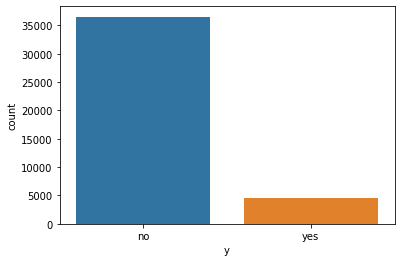

In [ ]:
sns.countplot(x='y',data=data)

🚩 The dataset is very skewed(<5000 entries for "yes"). This might cause problems in the future.

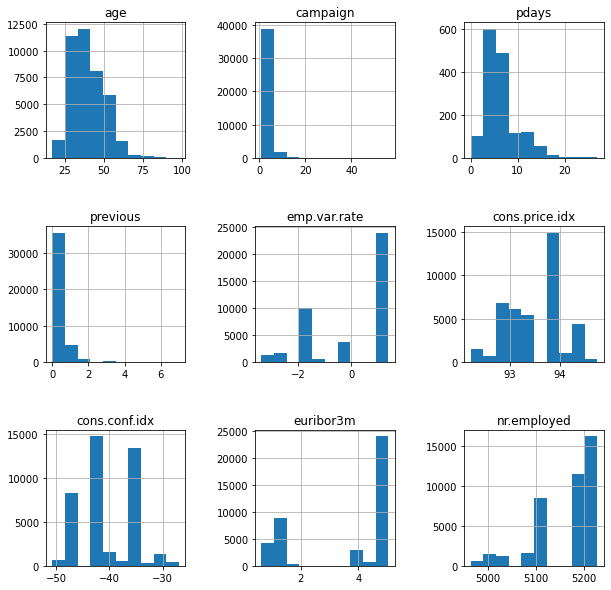

In [ ]:
header = ['age','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
data.hist(column=header,figsize=(10,10))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

## Normalization

In [ ]:
idx_numeric=[0, 10,11,12,13,15,16,17,18,19]
scaler = MinMaxScaler()
# scaler = StandardScaler()
# scaler = RobustScaler()
data[data.columns[idx_numeric]] = scaler.fit_transform(data[data.columns[idx_numeric]])

In [ ]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.481481,housemaid,married,basic.4y,no,no,no,telephone,may,mon,0.053070,0.0,NaN,0.0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,no
1,0.493827,services,married,high.school,NaN,no,no,telephone,may,mon,0.030297,0.0,NaN,0.0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,no
2,0.246914,services,married,high.school,no,yes,no,telephone,may,mon,0.045954,0.0,NaN,0.0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,no
3,0.283951,admin.,married,basic.6y,no,no,no,telephone,may,mon,0.030704,0.0,NaN,0.0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,no
4,0.481481,services,married,high.school,no,no,yes,telephone,may,mon,0.062424,0.0,NaN,0.0,nonexistent,0.9375,0.698753,0.60251,0.957379,0.859735,no


## Label Encoding

In [ ]:
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
data[categorical_cols] = data[categorical_cols].apply(lambda series: pd.Series(
    LabelEncoder().fit_transform(series[series.notnull()]),
    index=series[series.notnull()].index
))

In [ ]:
data['y'] = data['y'].map({'yes': 1, 'no': 0})

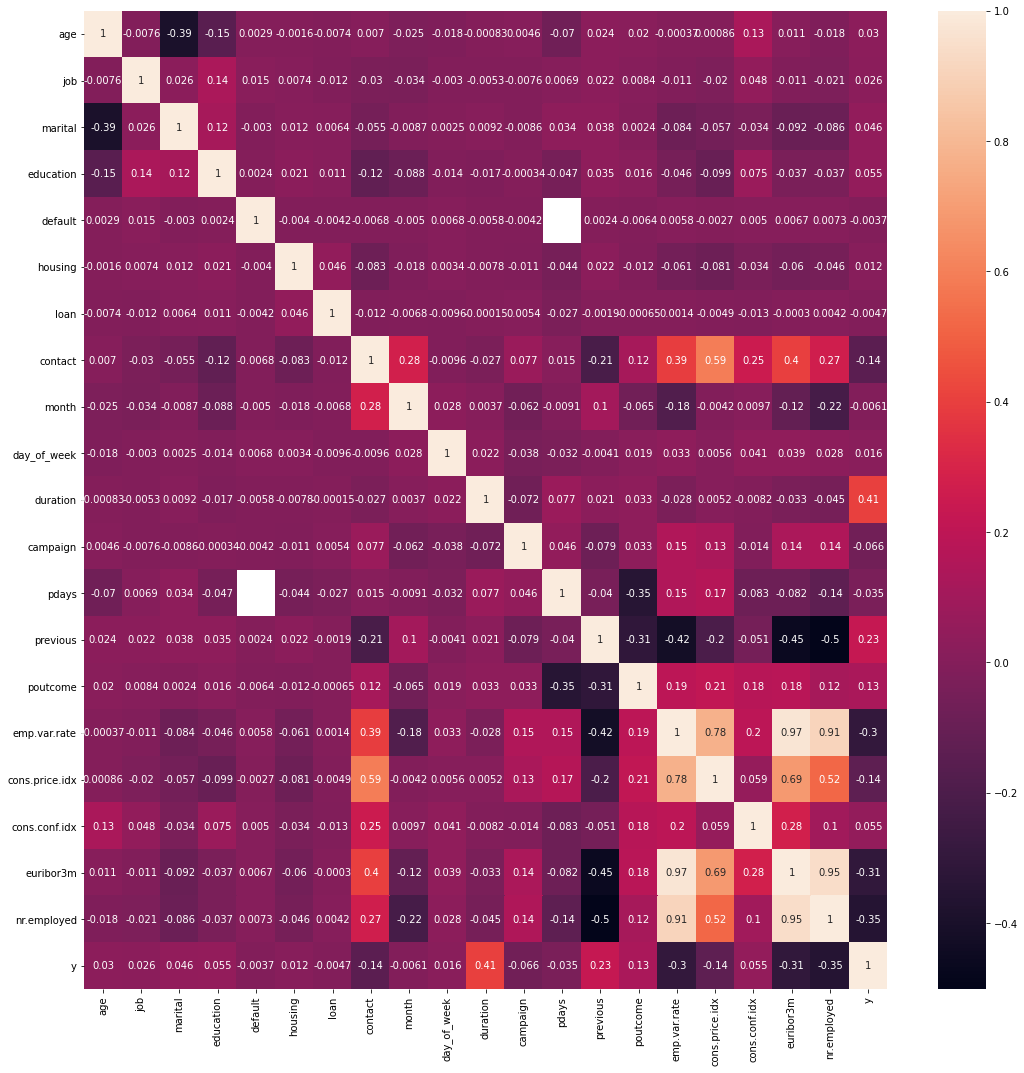

In [ ]:
plt.figure(figsize=(18,18))
sns.heatmap(data.corr(), annot=True)

The correlation plot doesn't really give much information about which features are the most important. Using all the features might be the way to go for now.

## Model Training

In [ ]:
X = data.drop(['y'], axis=1)
y = data['y']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.2)

In [ ]:
useTrainCV = True
cv_folds=5
early_stopping_rounds=10

In [ ]:
model = XGBClassifier()

if useTrainCV:
    print("Start Feeding Data")
    xgb_param = model.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train.values, label=Y_train.values)
    xgtest = xgb.DMatrix(X_test.values, label=Y_test.values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
                      early_stopping_rounds=early_stopping_rounds)
    model.set_params(n_estimators=cvresult.shape[0]) # we are only setting the no. of trees

print('Start Training')
model.fit(X_train, Y_train, eval_metric=['merror', 'auc'], verbose=True)

Start Feeding Data
Start Training


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=16, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
model.score(X_test, Y_test)

0.9129643117261471

## Hyperparameter Tuning using GridSearchCV

In [ ]:
def run_grid_search(estimator, params, X, Y, mode=1):
  if mode == 2:
    clf = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=-1, verbose=2, scoring=['accuracy', 'roc_auc'], refit=False)
    clf.fit(X, Y)
  else:
    clf = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=-1, verbose=2)
    clf.fit(X, Y)
  return clf

def run_random_search(estimator, params, X, Y, iter):
  clf = RandomizedSearchCV(estimator=estimator, param_distributions=params, n_jobs=-1, verbose=2, n_iter=iter, cv=3)
  clf.fit(X, Y)
  return clf

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [2, 3, 4, 5],
        'n_estimators': [50, 100, 150]
        }
clf = run_grid_search(estimator=XGBClassifier(), params=params, X=X_train, Y=Y_train, mode=1)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 37.0min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 51.0min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 68.7min


In [ ]:
clf.best_estimator_, clf.best_score_